# Franke function regression with Pytorch

Epoch 0 | Loss: 0.08287866413593292 | R2 Score -0.006356000900268555
Epoch 150 | Loss: 0.020615145564079285 | R2 Score 0.7496801614761353
Epoch 300 | Loss: 0.01933186873793602 | R2 Score 0.7652623653411865
Epoch 450 | Loss: 0.017965929582715034 | R2 Score 0.7818483114242554
Epoch 600 | Loss: 0.012322614900767803 | R2 Score 0.8503723740577698
Epoch 750 | Loss: 0.004679810721427202 | R2 Score 0.9431753158569336
Epoch 900 | Loss: 0.002436834154650569 | R2 Score 0.9704107046127319
Epoch 1050 | Loss: 0.0022858139127492905 | R2 Score 0.9722444415092468
Epoch 1200 | Loss: 0.0021640381310135126 | R2 Score 0.9737231135368347
Epoch 1350 | Loss: 0.0020402069203555584 | R2 Score 0.9752267599105835
Epoch 1500 | Loss: 0.0018081662710756063 | R2 Score 0.9780442714691162
Epoch 1650 | Loss: 0.0012716865167021751 | R2 Score 0.9845585227012634
Epoch 1800 | Loss: 0.0008541420102119446 | R2 Score 0.9896285533905029
Epoch 1950 | Loss: 0.0006839192355982959 | R2 Score 0.9916955232620239
Epoch 2100 | Loss: 0.

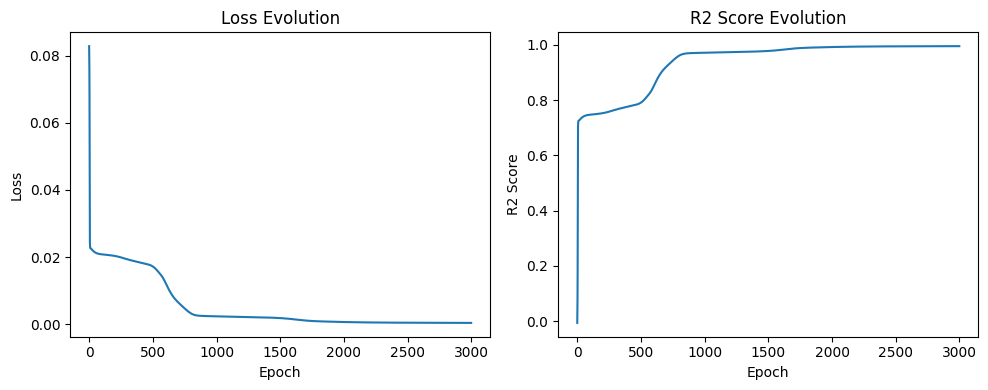

In [32]:
%pip install torcheval

import torch as torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torcheval.metrics import R2Score

#Define a fixed seed
np.random.seed(0)
torch.manual_seed(0)

#Franke function
def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

#Dataset
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)
x = X.flatten().reshape(-1, 1)
y = Y.flatten().reshape(-1, 1)
Z = FrankeFunction(x, y)

#Concatenate date & tensor-transform
data = np.concatenate((x, y), axis=1)
data = torch.tensor(data, dtype=torch.float32)
Z = torch.tensor(Z, dtype=torch.float32)

#Define the initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Define NN architecture
class Network(nn.Module):
    def __init__(self, input_size=2):
        super(Network, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, 50),
            nn.Sigmoid(),
            nn.Linear(50, 25),
            nn.Sigmoid(),
            nn.Linear(25, 1))

        self.network.apply(initialize_weights)

    def forward(self, x):
        return self.network(x)

#Model definition
model = Network(2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
loss = nn.MSELoss()
num_epochs = 3000
batch_size = 32
loss_evolution = []
r2_evolution = []
metric = R2Score()

#Random shuffling
perm = torch.randperm(data.size()[0])
data = data[perm]
Z = Z[perm]

#Training
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(data), batch_size):
        batch_data = data[i:i+batch_size]
        batch_target = Z[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_data)
        loss_value = loss(output, batch_target)
        loss_value.backward()
        optimizer.step()

    model.eval()
    output = model(data)
    loss_value = loss(output, Z)
    metric.update(output, Z)
    metric_value = metric.compute()

    loss_evolution.append(loss_value.item())
    r2_evolution.append(metric_value)
    if epoch % 150 == 0:
        print(f'Epoch {epoch} | Loss: {loss_value.item()} | R2 Score {metric_value}')
    metric.reset()

#Plotting
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss_evolution)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Evolution')

ax[1].plot(r2_evolution)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('R2 Score')
ax[1].set_title('R2 Score Evolution')

plt.tight_layout()
plt.show()

#Save the trained model for future
torch.save(model.state_dict(), 'nn_Franke.pth')

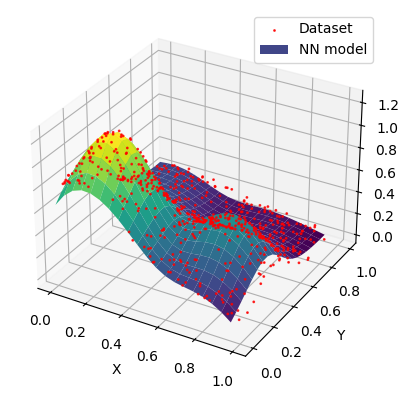


Loss:  0.00038032056181691587
R2 Score:  tensor(0.9954)


In [44]:
import warnings
warnings.filterwarnings('ignore')

#Load the model
model = Network(2)
model.load_state_dict(torch.load('nn_Franke.pth'))
model.eval()

#Random points on the surface
n=600
x = np.random.rand(n)
y = np.random.rand(n)
z = FrankeFunction(x,y)

#Points predicted by the network
xx = np.arange(0, 1, 0.05)
yy = np.arange(0, 1, 0.05)
xx, yy = np.meshgrid(xx,yy)
data = np.concatenate((xx.flatten().reshape(-1, 1), yy.flatten().reshape(-1, 1)), axis=1)
data = torch.tensor(data, dtype=torch.float32)
output = model(data)

#Plot the scatter points and the predicted surface
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#Plot with point size = 1
ax.scatter(x, y, z, c='r', marker='o', label="Dataset", alpha=0.8, s=1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

ax.plot_surface(xx, yy, output.detach().numpy().reshape(xx.shape), cmap='viridis', label="NN model")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

print("\nLoss: ", loss_evolution[-1])
print("R2 Score: ", r2_evolution[-1])

# Classification of Cancer Data with Pytorch

Epoch 0 | Train Loss: 0.670196533203125 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.6715782284736633 | Test Accuracy: 0.6228070175438597
Epoch 100 | Train Loss: 0.6499003171920776 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.6523462533950806 | Test Accuracy: 0.6228070175438597
Epoch 200 | Train Loss: 0.5519093871116638 | Train Accuracy: 0.6285714285714286 | Test Loss: 0.5489975810050964 | Test Accuracy: 0.6228070175438597
Epoch 300 | Train Loss: 0.22050587832927704 | Train Accuracy: 0.9494505494505494 | Test Loss: 0.19840706884860992 | Test Accuracy: 0.9649122807017544
Epoch 400 | Train Loss: 0.11597540974617004 | Train Accuracy: 0.9758241758241758 | Test Loss: 0.09833452850580215 | Test Accuracy: 0.9912280701754386
Epoch 500 | Train Loss: 0.08677607029676437 | Train Accuracy: 0.9802197802197802 | Test Loss: 0.07466215640306473 | Test Accuracy: 0.9824561403508771
Epoch 600 | Train Loss: 0.07404924929141998 | Train Accuracy: 0.9824175824175824 | Test Loss: 0.0655750632286

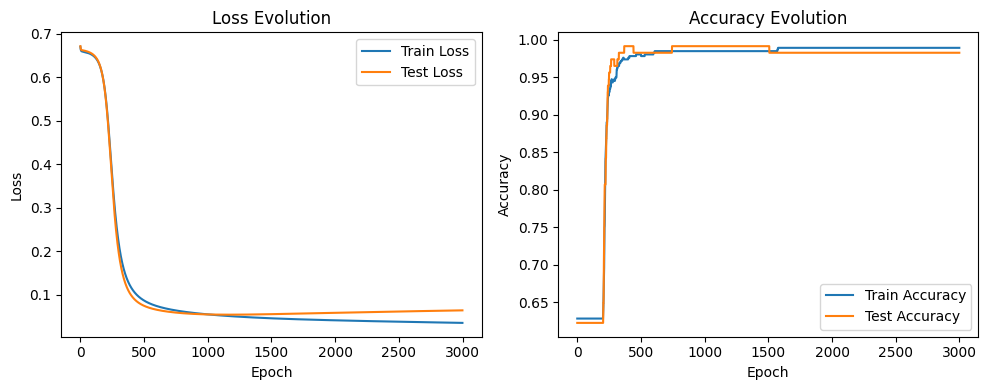

In [51]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#Load data
data = load_breast_cancer()
X = data.data
y = data.target
y_names = data.target_names

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Re-scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Transform to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

#Define the initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.1)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

#Define NN architecture
class Network(nn.Module):
    def __init__(self, input_size):
        super(Network, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(self.input_size, 10),
            nn.Sigmoid(),
            nn.Linear(10, 5),
            nn.Sigmoid(),
            nn.Linear(5, 2),
            )

        self.network.apply(initialize_weights)

    def forward(self, x):
        return self.network(x)

#Define the Accuracy function
def accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    total = target.size(0)
    return correct / total


#Model definition
model = Network(X.shape[1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss = nn.CrossEntropyLoss()
num_epochs = 3000
batch_size = 32

#Store metrics evolution
train_loss_evolution = []
train_accuracy_evolution = []
test_loss_evolution = []
accuracy_evolution = []

#Training
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train), batch_size):
        batch_data = X_train[i:i+batch_size]
        batch_target = y_train[i:i+batch_size]

        optimizer.zero_grad()
        output = model(batch_data)

        loss_value = loss(output, batch_target)
        loss_value.backward()
        optimizer.step()

    #Evaluate on train dataset
    model.eval()
    output = model(X_train)
    loss_value = loss(output, y_train)
    train_loss_evolution.append(loss_value.item())
    train_accuracy_evolution.append(accuracy(output, y_train))

    #Evaluate on test dataset
    output = model(X_test)
    loss_value = loss(output, y_test)
    test_loss_evolution.append(loss_value.item())
    accuracy_evolution.append(accuracy(output, y_test))

    if epoch % 100 == 0:
        print(f'Epoch {epoch} | Train Loss: {train_loss_evolution[-1]} | Train Accuracy: {train_accuracy_evolution[-1]} | Test Loss: {test_loss_evolution[-1]} | Test Accuracy: {accuracy_evolution[-1]}')

#Plotting
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_loss_evolution, label='Train Loss')
ax[0].plot(test_loss_evolution, label='Test Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Evolution')
ax[0].legend()

ax[1].plot(train_accuracy_evolution, label='Train Accuracy')
ax[1].plot(accuracy_evolution, label='Test Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy Evolution')
ax[1].legend()

plt.tight_layout()
plt.show()

#Save the trained model for future
torch.save(model.state_dict(), 'nn_cancer.pth')


# Logistic regression with Scikit Learn

Actual data
Train accuracy: 0.9626373626373627
Test accuracy: 0.956140350877193 

Scaled data
Train accuracy: 0.9868131868131869
Test accuracy: 0.9736842105263158

Cross validation scores: [0.98245614 0.9122807  0.92982456 0.94736842 0.98245614 0.98245614
 0.92982456 0.94736842 0.96491228 0.96428571]

Confusion matrix:
[[41  2]
 [ 1 70]]


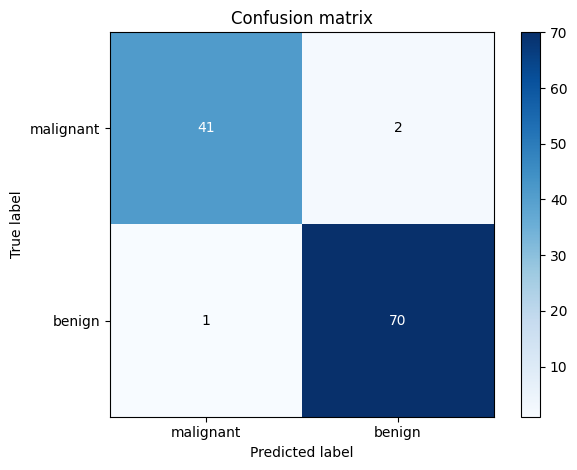

In [27]:
#Logistic regression with cancer data in Scikit Learn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

#Load data
data = load_breast_cancer()
X = data.data
y = data.target
y_names = data.target_names

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Logistic regression
logistic_regression = LogisticRegression(max_iter=10000, solver='lbfgs')
logistic_regression.fit(X_train, y_train)

#Scores
train_accuracy = logistic_regression.score(X_train, y_train)
test_accuracy = logistic_regression.score(X_test, y_test)
print(f'Actual data\nTrain accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy} \n')

#Repeat with scaled data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logistic_regression.fit(X_train_scaled, y_train)
train_accuracy = logistic_regression.score(X_train_scaled, y_train)
test_accuracy = logistic_regression.score(X_test_scaled, y_test)
print(f'Scaled data\nTrain accuracy: {train_accuracy}')
print(f'Test accuracy: {test_accuracy}\n')

#Cross validate the model
from sklearn.model_selection import cross_validate
scores = cross_validate(logistic_regression, X, y, cv=10)['test_score']
print(f'Cross validation scores: {scores}')


#Compute confusion matrix
from sklearn.metrics import confusion_matrix
y_pred = logistic_regression.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion matrix:\n{cm}')

#Plotting the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=y_names, yticklabels=y_names,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white"
                if cm[i, j] > cm.max() / 2. else "black")
fig.tight_layout()
plt.show()
